# Collection of modules for image analysis
### March 13,2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

import subprocess as sp
import os
import glob
import itertools

from scipy import fftpack
from matplotlib.colors import LogNorm, PowerNorm, Normalize


In [2]:
def f_plot_grid(arr,cols=16,fig_size=(15,5)):
    ''' Plot a grid of images
    '''
    size=arr.shape[0]    
    rows=int(np.ceil(size/cols))
    print(rows,cols)
    
    fig,axarr=plt.subplots(rows,cols,figsize=fig_size, gridspec_kw = {'wspace':0, 'hspace':0})
    if rows==1: axarr=np.reshape(axarr,(rows,cols))
    if cols==1: axarr=np.reshape(axarr,(rows,cols))
    
    for i in range(min(rows*cols,size)):
        row,col=int(i/cols),i%cols
        try: 
            axarr[row,col].imshow(arr[i],origin='lower', cmap='YlGn', extent = [0, 128, 0, 128], norm=Normalize(vmin=-1., vmax=1.))
        # Drop axis label
        except Exception as e:
            print('Exception:',e)
            pass
        temp=plt.setp([a.get_xticklabels() for a in axarr[:-1,:].flatten()], visible=False)
        temp=plt.setp([a.get_yticklabels() for a in axarr[:,1:].flatten()], visible=False)

def f_plot_intensity_grid(arr,cols=5,fig_size=(12,12)):
    '''
    Module to plot the pixel intensity histograms for a set of images on a gird
    '''
    size=arr.shape[0]
    assert cols<=size, "cols %s greater than array size %s"%(cols,size)
    
    num=arr.shape[0]
    rows=int(np.ceil(size/cols))
#     print(rows,cols)

#     print("Plotting %s images" %(rows*cols))
    fig,axarr=plt.subplots(rows,cols,figsize=fig_size,constrained_layout=True)
    for i in range(rows*cols):
        row,col=int(i/cols),i%cols
        ### Get histogram
        try: 
            img_arr=arr[i]
            norm=False
            hist, bin_edges = np.histogram(img_arr.flatten(), bins=25, density=norm)
            centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            axarr[row,col].errorbar(centers,hist,fmt='o-')
#         fig.subplots_adjust(left=0.01,bottom=0.01,right=0.1,top=0.1,wspace=0.001,hspace=0.0001)
        except Exception as e:
            print('error',e)


In [3]:
def f_batch_histogram(img_arr,bins,norm,hist_range):
    ''' Compute histogram statistics for a batch of images'''

    ## Extracting the range. This is important to ensure that the different histograms are compared correctly
    if hist_range==None : ulim,llim=np.max(img_arr),np.min(img_arr)
    else: ulim,llim=hist_range[1],hist_range[0]
#     print(ulim,llim)
    ### array of histogram of each image
    hist_arr=np.array([np.histogram(arr.flatten(), bins=bins, range=(llim,ulim), density=norm) for arr in img_arr],dtype=object) ## range is important
    hist=np.stack(hist_arr[:,0]) # First element is histogram array
    bin_list=np.stack(hist_arr[:,1]) # Second element is bin value 
    
    ### Compute statistics over histograms of individual images
    mean,err=np.mean(hist,axis=0),np.std(hist,axis=0)/np.sqrt(hist.shape[0])
    bin_edges=bin_list[0]
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return mean,err,centers

def f_pixel_intensity(img_arr,bins=25,label='validation',mode='avg',normalize=False,log_scale=True,plot=True, hist_range=None):
    '''
    Module to compute and plot histogram for pixel intensity of images
    Has 2 modes : simple and avg
        simple mode: No errors. Just flatten the input image array and compute histogram of full data
        avg mode(Default) : 
            - Compute histogram for each image in the image array
            - Compute errors across each histogram 
    '''
    
    norm=normalize # Whether to normalize the histogram
    
    if plot: 
        plt.figure()
        plt.xlabel('Pixel value')
        plt.ylabel('Counts')
        plt.title('Pixel Intensity Histogram')

        if log_scale: plt.yscale('log')
    
    if mode=='simple':
        hist, bin_edges = np.histogram(img_arr.flatten(), bins=bins, density=norm, range=hist_range)
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        if plot: plt.errorbar(centers, hist, fmt='o-', label=label)
        return hist,None
    
    elif mode=='avg': 
        ### Compute histogram for each image. 
        mean,err,centers=f_batch_histogram(img_arr,bins,norm,hist_range)

        if plot: plt.errorbar(centers,mean,yerr=err,fmt='o-',label=label)  
        return mean,err
    
def f_compare_pixel_intensity(img_lst,label_lst=['img1','img2'],bkgnd_arr=[],log_scale=True, normalize=True, mode='avg',bins=25, hist_range=None):
    '''
    Module to compute and plot histogram for pixel intensity of images
    Has 2 modes : simple and avg
    simple mode: No errors. Just flatten the input image array and compute histogram of full data
    avg mode(Default) : 
        - Compute histogram for each image in the image array
        - Compute errors across each histogram 
        
    bkgnd_arr : histogram of this array is plotting with +/- sigma band
    '''
    
    norm=normalize # Whether to normalize the histogram
    
    plt.figure()
    
    ## Plot background distribution
    if len(bkgnd_arr):
        if mode=='simple':
            hist, bin_edges = np.histogram(bkgnd_arr.flatten(), bins=bins, density=norm, range=hist_range)
            centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            plt.errorbar(centers, hist, color='k',marker='*',linestyle=':', label='bkgnd')

        elif mode=='avg':
            ### Compute histogram for each image. 
            mean,err,centers=f_batch_histogram(bkgnd_arr,bins,norm,hist_range)
            plt.plot(centers,mean,linestyle=':',color='k',label='bkgnd')
            plt.fill_between(centers, mean - err, mean + err, color='k', alpha=0.4)
    
    ### Plot the rest of the datasets
    for img,label,mrkr in zip(img_lst,label_lst,itertools.cycle('o^*sDHPdpx_>')):     
        if mode=='simple':
            hist, bin_edges = np.histogram(img.flatten(), bins=bins, density=norm, range=hist_range)
            centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            plt.errorbar(centers, hist, fmt=mrkr+'-', label=label)

        elif mode=='avg':
            ### Compute histogram for each image. 
            mean,err,centers=f_batch_histogram(img,bins,norm,hist_range)
#             print('Centers',centers)
            plt.errorbar(centers,mean,yerr=err,fmt=mrkr+'-',label=label)

    if log_scale: 
        plt.yscale('log')
        plt.xscale('symlog',linthreshx=50)

    plt.legend()
    plt.xlabel('Pixel value')
    plt.ylabel('Counts')
    plt.title('Pixel Intensity Histogram')
    




## Spectral modules

<!-- %%latex  -->
### Formulae
Image gives 
$$ I(x,y) $$

Fourier transform 
$$ F(k_x, k_y) = \int \left[ I \ e^{-2 \pi i \bar{x}} \right] dx dy $$

1D average 
$$ F(k) = \int \left [ d \theta \right]$$

In [4]:

def f_get_azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    source: https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    """
    # Create a grid of points with x and y coordinates
    y, x = np.indices(image.shape)
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    # Get the radial coordinate for every grid point. Array has the shape of image
    r = np.hypot(x - center[0], y - center[1])

    ind = np.argsort(r.flat) ### Get indices that sort the "r" array in ascending order.

    r_sorted = r.flat[ind]     ### Sort the "r" array
    
    i_sorted = image.flat[ind]   ### Sort the image points according to the radial coordinate

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


def f_radial_profile(data, center=None):
    ''' Module to compute radial profile of a 2D image '''
    y, x = np.indices((data.shape)) # Get a grid of x and y values
    
    if not center: center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0]) # compute centers
    # get radial values of every pair of points
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    
    # Compute histogram of r values
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel()) 
    radialprofile = tbin / nr
    
    ### The [1:-1] is to keep consistency with the module f_get_azimuthalAverage above, since that one is also used in the pytorch code
    return radialprofile[1:-1]


def f_get_power_spectrum(image,GLOBAL_MEAN=0.9998563):
    """
    Computes azimuthal average of 2D power spectrum of a np array image
    GLOBAL_MEAN is the mean pixel value of the training+validation datasets
    """
    ### Compute 2D fourier. transform
    F1 = fftpack.fft2((image - GLOBAL_MEAN)/GLOBAL_MEAN)
    F2 = fftpack.fftshift(F1)
    ### Absolute value of F-transform
    pspec2d = np.abs(F2)**2
    
    ### Compute azimuthal average
#     P_k = f_get_azimuthalAverage(pspec2d)
    P_k = f_radial_profile(pspec2d)
    
    return P_k


def f_batch_spectrum(arr):
    """Computes power spectrum for a batch of images"""
    P_k=[f_get_power_spectrum(i) for i in arr]
    return np.array(P_k)


def f_compute_spectrum(img_arr,plot=False,label='input',log_scale=True):
    '''
    Module to compute Average of the 1D spectrum
    '''
    num = img_arr.shape[0]
    Pk = f_batch_spectrum(img_arr)

    mean,std = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])
    k=np.arange(len(mean))
    
    if plot: 
        plt.figure()
        plt.plot(k, mean, 'k:')
        plt.plot(k, mean + std, 'k-',label=label)
        plt.plot(k, mean - std, 'k-')
    #     plt.xscale('log')
        if log_scale: plt.yscale('log')
        plt.ylabel(r'$P(k)$')
        plt.xlabel(r'$k$')
        plt.title('Power Spectrum')
        plt.legend()
    
    return mean,std

def f_compare_spectrum(img_lst,label_lst=['img1','img2'],bkgnd_arr=[],log_scale=True):
    '''
    Compare the spectrum of 2 sets of images: 
    img_lst contains the set of images arrays, Each is of the form (num_images,height,width)
    label_lst contains the labels used in the plot
    '''
    plt.figure()
    
    ## Plot background distribution
    if len(bkgnd_arr):
        Pk= f_batch_spectrum(bkgnd_arr)
        mean,err = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])
        k=np.arange(len(mean))
        plt.plot(k, mean,color='k',linestyle='-',label='bkgnd')    
        plt.fill_between(k, mean - err, mean + err, color='k',alpha=0.8)
    
    
    for img_arr,label,mrkr in zip(img_lst,label_lst,itertools.cycle('>^*sDHPdpx_')): 
        Pk= f_batch_spectrum(img_arr)
        mean,err = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])

        k=np.arange(len(mean))
#         print(mean.shape,std.shape)
        plt.fill_between(k, mean - err, mean + err, alpha=0.4)
        plt.plot(k, mean, marker=mrkr, linestyle=':',label=label)

    if log_scale: plt.yscale('log')
    plt.ylabel(r'$P(k)$')
    plt.xlabel(r'$k$')
    plt.title('Power Spectrum')
    plt.legend()  



#### 3D image spectrum

In [5]:
# ### Spectral modules

# In[ ]:


## numpy code
def f_radial_profile_3d(data, center=(None,None)):
    ''' Module to compute radial profile of a 2D image '''
    
    z, y, x = np.indices((data.shape)) # Get a grid of x and y values
    
    center=[]
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0, (z.max()-z.min())/2.0]) # compute centers
        
    # get radial values of every pair of points
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2+ + (z - center[2])**2)
    r = r.astype(np.int)
    
    # Compute histogram of r values
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel()) 
    radialprofile = tbin / nr
    
    return radialprofile[1:-1]

def f_compute_spectrum_3d(arr):
    '''
    compute spectrum for a 3D image
    '''
#     GLOBAL_MEAN=1.0
#     arr=((arr - GLOBAL_MEAN)/GLOBAL_MEAN)
    y1=np.fft.fftn(arr)
    y1=np.fft.fftshift(y1)
#     print(y1.shape)
    y2=abs(y1)**2
    z1=f_radial_profile_3d(y2)
    return(z1)
   
def f_batch_spectrum_3d(arr):
    batch_pk=np.array([f_compute_spectrum_3d(i) for i in arr])
    return batch_pk

### Code ###
def f_image_spectrum_3d(x,num_channels):
    '''
    Compute spectrum when image has a channel index
    Data has to be in the form (batch,channel,x,y)
    '''
    mean=[[] for i in range(num_channels)]    
    var=[[] for i in range(num_channels)]    

    for i in range(num_channels):
        arr=x[:,i,:,:,:]
#         print(i,arr.shape)
        batch_pk=f_batch_spectrum_3d(arr)
#         print(batch_pk)
        mean[i]=np.mean(batch_pk,axis=0)
        var[i]=np.var(batch_pk,axis=0)
    
    mean=np.array(mean)
    var=np.array(var)
    return mean,var

def f_plot_spectrum_3d(img_arr,plot=False,label='input',log_scale=True):
    '''
    Module to compute Average of the 1D spectrum for a batch of 3d images
    '''
    num = img_arr.shape[0]
    Pk = f_batch_spectrum_3d(img_arr)

    #mean,std = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])
    mean,std = np.mean(Pk, axis=0),np.std(Pk, axis=0)
    k=np.arange(len(mean))
    
    if plot: 
        plt.figure()
        plt.plot(k, mean, 'k:')
        plt.plot(k, mean + std, 'k-',label=label)
        plt.plot(k, mean - std, 'k-')
    #     plt.xscale('log')
        if log_scale: plt.yscale('log')
        plt.ylabel(r'$P(k)$')
        plt.xlabel(r'$k$')
        plt.title('Power Spectrum')
        plt.legend()

    return mean,std


def f_compare_spectrum_3d(img_lst,label_lst=['img1','img2'],bkgnd_arr=[],log_scale=True):
    '''
    Compare the spectrum of 2 sets s: 
    img_lst contains the set of images arrays, Each is of the form (num_images,height,width)
    label_lst contains the labels used in the plot
    '''
    plt.figure()
    
    ## Plot background distribution
    if len(bkgnd_arr):
        Pk= f_batch_spectrum_3d(bkgnd_arr)
        mean,err = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])
        k=np.arange(len(mean))
        plt.plot(k, mean,color='k',linestyle='-',label='bkgnd')    
        plt.fill_between(k, mean - err, mean + err, color='k',alpha=0.8)
    
    
    for img_arr,label,mrkr in zip(img_lst,label_lst,itertools.cycle('>^*sDHPdpx_')): 
        Pk= f_batch_spectrum_3d(img_arr)
        mean,err = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])

        k=np.arange(len(mean))
#         print(mean.shape,std.shape)
        plt.fill_between(k, mean - err, mean + err, alpha=0.4)
        plt.plot(k, mean, marker=mrkr, linestyle=':',label=label)

    if log_scale: plt.yscale('log')
    plt.ylabel(r'$P(k)$')
    plt.xlabel(r'$k$')
    plt.title('Power Spectrum')
    plt.legend()  
    

In [6]:
! jupyter nbconvert --to script modules_image_analysis.ipynb

[NbConvertApp] WARNING | pattern 'modules_image_analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is t

## Test

(1000, 1, 128)
6 3


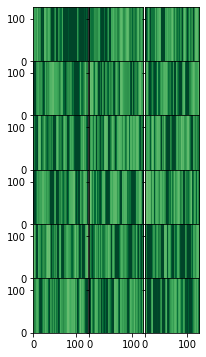

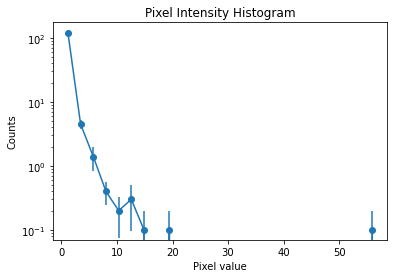

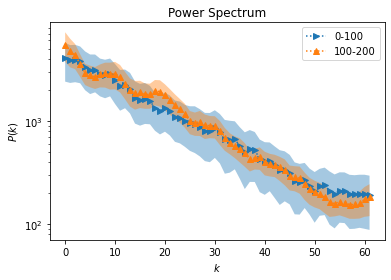

In [8]:
if __name__=='__main__':
    
    data_dir = '/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/128_square/dataset_2_smoothing_200k/'
    fname='full_with_smoothing_1.npy'
    samples = np.load(data_dir+fname ,mmap_mode='r',allow_pickle=True)[:1000]
    samples = samples.transpose(0,3,1,2)[:,0,:,:]
    print(samples.shape)
    img=samples[20]


    ## Use functions
    f_plot_grid(samples[:18],cols=3,fig_size=(3,6))
    f_pixel_intensity(samples[:10])
#     f_plot_intensity_grid(samples[:20],cols=5)
    f_get_power_spectrum(img)
    f_compute_spectrum(samples[:100])
    f_compare_spectrum([samples[:100],samples[100:200]],['0-100','100-200'])


In [ ]:
if __name__=='__main__':
    
    data_dir = '/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/128_square/dataset_2_smoothing_200k/'
    fname='full_with_smoothing_1.npy'
    samples = np.load(data_dir+fname ,mmap_mode='r',allow_pickle=True)[:1000]
    samples = samples.transpose(0,3,1,2)[:,0,:,:]
    print(samples.shape)
    img=samples[20]


    ## Use functions
    f_plot_grid(samples[:18],cols=3,fig_size=(3,6))
    f_pixel_intensity(samples[:10])
#     f_plot_intensity_grid(samples[:20],cols=5)
    f_get_power_spectrum(img)
    f_compute_spectrum(samples[:100])
    f_compare_spectrum([samples[:100],samples[100:200]],['0-100','100-200'])
